# **Proyecto Final de IA2: Autoencoders para colorear imágenes**

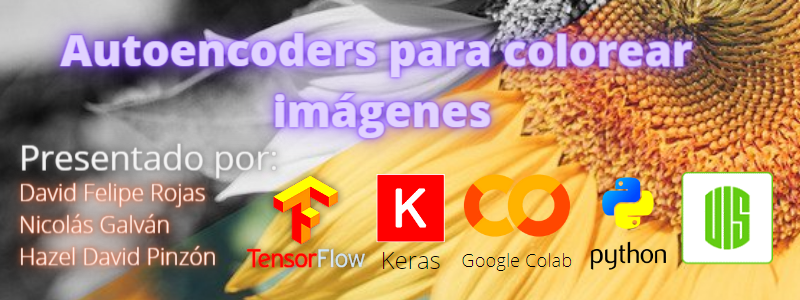

La coloración de imágenes mediante diferentes programas requiere una gran cantidad de esfuerzo humano, tiempo y habilidad, pero un tipo especial de arquitectura de deep learning llamada "autoencoder" ha facilitado mucho esta tarea. La coloración automática de imágenes suele implicar el uso de una clase de redes neuronales convolucionales (CNN) denominadas autoencoders, las cuales son capaces de extraer las características más destacadas de una imagen y, a continuación, regenerar la imagen basándose en estas características aprendidas. 

El objetivo principal de este proyecto es crear un autoencoder que pueda colorear imágenes de paisajes en escala de grises.

**Integrantes:**
- David Felipe Rojas Casadiego. 2170136
- Nicolas Galvan Alvarez. 2170104  
- Hazel David Pinzón Uribe. 2163022

## Librerías necesarias

In [1]:
!pip install sewar

  Created wheel for sewar: filename=sewar-0.4.4-py3-none-any.whl size=10390 sha256=04116f05ae6e2e711b0d828b84f874b61d2a960b1453162eb551a756b7324f96
  Stored in directory: /root/.cache/pip/wheels/b5/00/df/f1ba40d0d44c95b0db52804e518c128d5631866b91ea1960ba
Successfully built sewar


In [2]:
!pip3 install image-similarity-measures

     |████████████████████████████████| 2.6 MB 7.1 MB/s 
     |████████████████████████████████| 19.3 MB 1.4 MB/s 
  Created wheel for phasepack: filename=phasepack-1.5-py3-none-any.whl size=26983 sha256=e3870ec6a0cace242a45fb3fcfdfcc95f032872f6a7ce442e7abc2ce68cd5ccc
  Stored in directory: /root/.cache/pip/wheels/39/5c/b3/79292d7ac3f088e858805b5515b45cf5a365106397d936caf1
Successfully built phasepack


In [3]:
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp

In [4]:
import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, ssim, sre

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras import layers
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Descarga del dataset desde Kaggle

In [7]:
! mkdir ~/.kaggle

In [8]:
!git clone https://github.com/hazel1399/ProyectoIA2.git

Cloning into 'ProyectoIA2'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 31 (delta 8), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.


In [9]:
! cp /content/ProyectoIA2/kaggle.json ~/.kaggle/

In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
! kaggle datasets download theblackmamba31/landscape-image-colorization

 97% 186M/192M [00:02<00:00, 89.3MB/s]
100% 192M/192M [00:02<00:00, 74.8MB/s]


In [12]:
if (os.path.isdir('landscape Images')==False):
  !unzip -q landscape-image-colorization.zip

# Autoencoder

## Tratamiento de los datos
Para obtener las imágenes en orden hemos definido la función sorted_alphanumeric. Aquí, hemos utilizado la biblioteca opencv para leer y cambiar el tamaño de las imágenes. Finalmente las imágenes se normalizan y se convierten en un array y se añaden a una lista.

In [ ]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
path = '/content/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '3000.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
path = '/content/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '3000.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))
         
   

 42%|████▏     | 3000/7129 [00:02<00:03, 1053.29it/s]


### Ejemplo de imágenes

In [ ]:
# función para plotear pares de imágenes en grises y a color
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()

**Ejemplo de imágenes en el dataset**

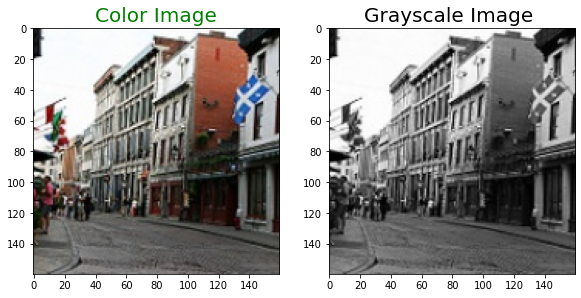

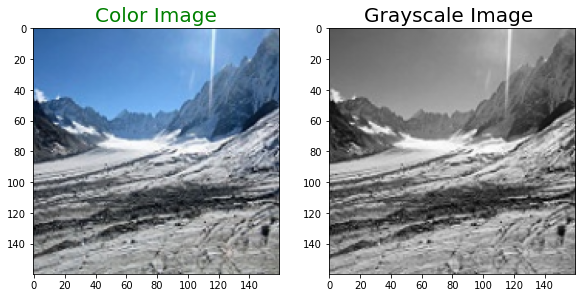

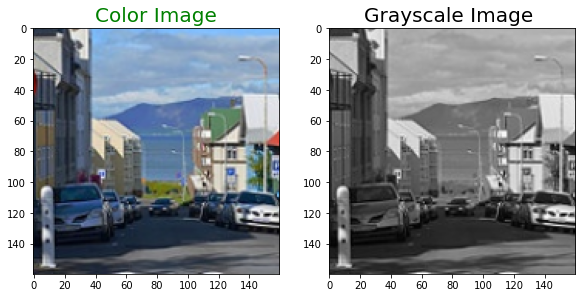

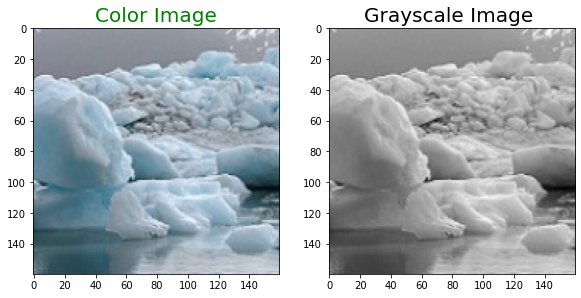

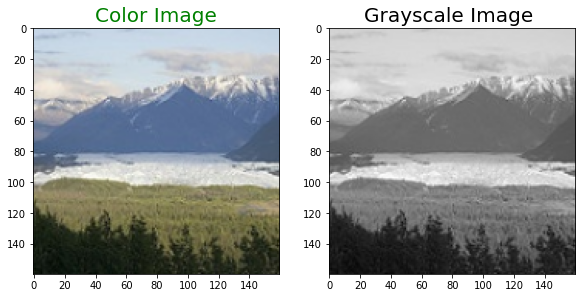

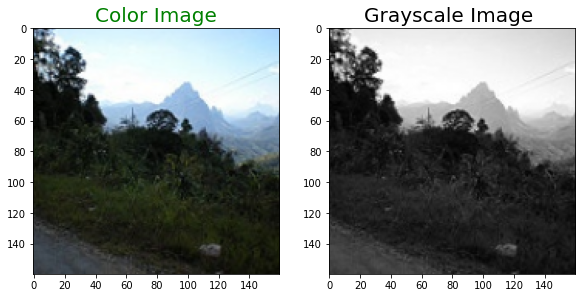

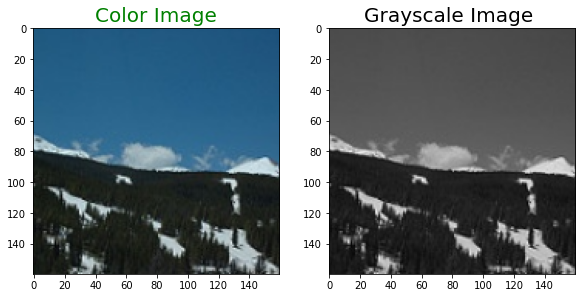

In [ ]:
for i in range(3,10):
     plot_images(color_img[i],gray_img[i])

### División del dataset
De las 3.000 imágenes, las hemos dividido en dos partes: las imágenes de entrenamiento constan de 2.500 imágenes, mientras que las imágenes de prueba contienen 500 imágenes. Después de dividir la matriz de imágenes, les hemos aplicado un reshape para que las imágenes puedan introducirse directamente en nuestra red neuronal.

In [ ]:
train_gray_image = gray_img[:2500]
train_color_image = color_img[:2500]

test_gray_image = gray_img[2500:]
test_color_image = color_img[2500:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (2500, 160, 160, 3)
Test color image shape (500, 160, 160, 3)


In [ ]:
import gc

del gray_img
del color_img


gc.collect()



25016

In [ ]:
del img
gc.collect()


50

## Definición del modelo sin concatenar capas

In [ ]:
input_img = tf.keras.layers.Input(shape=[160,160,3])

encoded = tf.keras.models.Sequential()
encoded = tf.keras.layers.Conv2D(128,(3,3),padding = 'same', strides = 2)(input_img)
encoded = tf.keras.layers.LeakyReLU()(encoded)

encoded = tf.keras.layers.Conv2D(256,(3,3),padding = 'same', strides = 2)(encoded)
encoded = tf.keras.layers.BatchNormalization()(encoded)
encoded = tf.keras.layers.LeakyReLU()(encoded)

encoded = tf.keras.layers.Conv2D(512,(3,3),padding = 'same', strides = 2)(encoded)
encoded = tf.keras.layers.BatchNormalization()(encoded)
encoded = tf.keras.layers.LeakyReLU()(encoded)

decoded = tf.keras.models.Sequential()

decoded = tf.keras.layers.Conv2DTranspose(256,(3,3),padding = 'same', strides = 2)(encoded)
decoded = tf.keras.layers.LeakyReLU()(decoded)

decoded = tf.keras.layers.Conv2DTranspose(128,(3,3),padding = 'same', strides = 2)(decoded)
decoded = tf.keras.layers.LeakyReLU()(decoded)

decoded = tf.keras.layers.Conv2DTranspose(3,(3,3),padding = 'same', strides = 2)(decoded)
decoded = tf.keras.layers.LeakyReLU()(decoded)
output = tf.keras.layers.Conv2D(3,(2,2),padding = 'same',strides = 1)(decoded)


autoencoder = tf.keras.models.Model(input_img, output)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 80, 80, 128)       3584      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 80, 80, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 40, 40, 256)       295168    
_________________________________________________________________
batch_normalization_5 (Batch (None, 40, 40, 256)       1024      
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 40, 40, 256)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 20, 20, 512)       1180

### Compilación y verificación del modelo

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="modelo-AE-noconcatL.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

In [ ]:
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['accuracy'])

history = autoencoder.fit(train_g, train_c, epochs = 50,validation_split=0.05,batch_size = 50,callbacks=[checkpointer, tensorboard],verbose = 1).history

Epoch 1/50
48/48 [==============================] - 28s 536ms/step - loss: 0.2474 - accuracy: 0.3528 - val_loss: 0.1754 - val_accuracy: 0.3220
Epoch 2/50
48/48 [==============================] - 25s 516ms/step - loss: 0.1117 - accuracy: 0.3631 - val_loss: 0.1877 - val_accuracy: 0.3441
Epoch 3/50
48/48 [==============================] - 25s 520ms/step - loss: 0.0946 - accuracy: 0.3964 - val_loss: 0.1836 - val_accuracy: 0.3468
Epoch 4/50
48/48 [==============================] - 25s 522ms/step - loss: 0.0921 - accuracy: 0.4089 - val_loss: 0.1654 - val_accuracy: 0.3917
Epoch 5/50
48/48 [==============================] - 25s 522ms/step - loss: 0.0839 - accuracy: 0.4176 - val_loss: 0.1376 - val_accuracy: 0.4050
Epoch 6/50
48/48 [==============================] - 25s 521ms/step - loss: 0.0850 - accuracy: 0.4196 - val_loss: 0.1289 - val_accuracy: 0.4129
Epoch 7/50
48/48 [==============================] - 25s 518ms/step - loss: 0.0768 - accuracy: 0.4382 - val_loss: 0.1115 - val_accuracy: 0.4454

### Test del modelo

In [ ]:
from keras.models import Model, load_model
autoencoder = load_model('/content/drive/MyDrive/Proyecto-IA2/Modelos/modelo-AE-noconcatl.h5')

In [ ]:
autoencoder.evaluate(test_gray_image,test_color_image)

16/16 [==============================] - 3s 156ms/step - loss: 0.0580 - accuracy: 0.4546


[0.05800588056445122, 0.45463845133781433]

In [ ]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Imagen a color', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Imagen blanco y negro ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Imagen predicha ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

mse_ncL, rmse_ncL, psnr_ncL, fsim_ncL, uqi_ncL, ssim_ncL, uiq_ncL, vif_ncL = [],[],[],[],[],[],[],[]
for i in range(len(test_gray_image)):
    predicted = np.clip(autoencoder.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    if i in range(51,58):
      plot_images(test_color_image[i],test_gray_image[i],predicted)
    mse_ncL.append(mse(predicted,test_color_image[i]))
    rmse_ncL.append(rmse(predicted, test_color_image[i]))
    psnr_ncL.append(image_similarity_measures.quality_metrics.psnr(predicted, test_color_image[i]))
    fsim_ncL.append(image_similarity_measures.quality_metrics.fsim(predicted, test_color_image[i]))
    uqi_ncL.append(uqi(predicted, test_color_image[i]))
    ssim_ncL.append(image_similarity_measures.quality_metrics.ssim(predicted, test_color_image[i]))
    vif_ncL.append(vifp(predicted, test_color_image[i]))

mse_nCL_m=np.mean(mse_ncL)
rmse_ncL_m=np.mean(rmse_ncL)
psnr_ncL_m=np.mean(psnr_ncL)
fsim_ncL_m=np.mean(fsim_ncL)
uqi_ncL_m=np.mean(uqi_ncL)
ssim_ncL_m=np.mean(ssim_ncL)
vif_ncL_m=np.mean(vif_ncL)

AE_ncL=np.array([mse_nCL_m,rmse_ncL_m,psnr_ncL_m,fsim_ncL_m,uqi_ncL_m,ssim_ncL_m,vif_ncL_m])

Output hidden; open in https://colab.research.google.com to view.

## Definición del modelo sin concatenar y aumentando las capas

In [ ]:
input_img = tf.keras.layers.Input(shape=[160,160,3])

encoded = tf.keras.models.Sequential()
encoded = tf.keras.layers.Conv2D(128,(3,3),padding = 'same', strides = 2)(input_img)
encoded = tf.keras.layers.LeakyReLU()(encoded)
encoded = tf.keras.layers.Conv2D(128,(3,3),padding = 'same', strides = 2)(encoded)
encoded = tf.keras.layers.LeakyReLU()(encoded)
encoded = tf.keras.layers.Conv2D(256,(3,3),padding = 'same', strides = 2)(encoded)
encoded = tf.keras.layers.BatchNormalization()(encoded)
encoded = tf.keras.layers.LeakyReLU()(encoded)
encoded = tf.keras.layers.Conv2D(512,(3,3),padding = 'same', strides = 2)(encoded)
encoded = tf.keras.layers.BatchNormalization()(encoded)
encoded = tf.keras.layers.LeakyReLU()(encoded)
encoded = tf.keras.layers.Conv2D(512,(3,3),padding = 'same', strides = 2)(encoded)
encoded = tf.keras.layers.BatchNormalization()(encoded)
encoded = tf.keras.layers.LeakyReLU()(encoded)

decoded = tf.keras.models.Sequential()
decoded = tf.keras.layers.Conv2DTranspose(512,(3,3),padding = 'same', strides = 2)(encoded)
decoded = tf.keras.layers.LeakyReLU()(decoded)
decoded = tf.keras.layers.Conv2DTranspose(256,(3,3),padding = 'same', strides = 2)(decoded)
decoded = tf.keras.layers.LeakyReLU()(decoded)
decoded = tf.keras.layers.Conv2DTranspose(128,(3,3),padding = 'same', strides = 2)(decoded)
decoded = tf.keras.layers.LeakyReLU()(decoded)
decoded = tf.keras.layers.Conv2DTranspose(128,(3,3),padding = 'same', strides = 2)(decoded)
decoded = tf.keras.layers.LeakyReLU()(decoded)
decoded = tf.keras.layers.Conv2DTranspose(3,(3,3),padding = 'same', strides = 2)(decoded)
decoded = tf.keras.layers.LeakyReLU()(decoded)
output = tf.keras.layers.Conv2D(3,(2,2),padding = 'same',strides = 1)(decoded)


autoencoder = tf.keras.models.Model(input_img, output)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 128)       3584      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 80, 80, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       147584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 256)       295168    
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 20, 256)       1024  

### Compilación y verificación del modelo

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="modelo-AE-noconcatM.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

In [ ]:
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['accuracy'])

history = autoencoder.fit(train_g, train_c, epochs = 50,validation_split=0.05,batch_size = 50,callbacks=[checkpointer, tensorboard],verbose = 1).history

Epoch 1/50
48/48 [==============================] - 21s 400ms/step - loss: 0.2217 - accuracy: 0.3011 - val_loss: 0.5120 - val_accuracy: 0.3646
Epoch 2/50
48/48 [==============================] - 18s 369ms/step - loss: 0.1191 - accuracy: 0.3599 - val_loss: 0.2127 - val_accuracy: 0.3416
Epoch 3/50
48/48 [==============================] - 18s 371ms/step - loss: 0.1111 - accuracy: 0.3907 - val_loss: 0.1135 - val_accuracy: 0.4013
Epoch 4/50
48/48 [==============================] - 18s 370ms/step - loss: 0.1104 - accuracy: 0.3876 - val_loss: 0.1181 - val_accuracy: 0.4111
Epoch 5/50
48/48 [==============================] - 18s 378ms/step - loss: 0.1066 - accuracy: 0.3905 - val_loss: 0.1160 - val_accuracy: 0.3578
Epoch 6/50
48/48 [==============================] - 18s 378ms/step - loss: 0.1026 - accuracy: 0.3969 - val_loss: 0.1089 - val_accuracy: 0.3661
Epoch 7/50
48/48 [==============================] - 18s 373ms/step - loss: 0.1034 - accuracy: 0.3939 - val_loss: 0.1112 - val_accuracy: 0.3981

### Test del modelo

In [ ]:
from keras.models import Model, load_model
autoencoder = load_model('/content/drive/MyDrive/Proyecto-IA2/Modelos/modelo-AE-noconcatM.h5')

In [ ]:
autoencoder.evaluate(test_gray_image,test_color_image)

16/16 [==============================] - 2s 97ms/step - loss: 0.0575 - accuracy: 0.6707


[0.057476479560136795, 0.6706987619400024]

In [ ]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Imagen a color', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Imagen blanco y negro ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Imagen predicha ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

mse_ncM, rmse_ncM, psnr_ncM, fsim_ncM, uqi_ncM, ssim_ncM, uiq_ncM, vif_ncM = [],[],[],[],[],[],[],[]
for i in range(len(test_gray_image)):
    predicted = np.clip(autoencoder.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    if i in range(51,58):
      plot_images(test_color_image[i],test_gray_image[i],predicted)
    mse_ncM.append(mse(predicted,test_color_image[i]))
    rmse_ncM.append(rmse(predicted, test_color_image[i]))
    psnr_ncM.append(image_similarity_measures.quality_metrics.psnr(predicted, test_color_image[i]))
    fsim_ncM.append(image_similarity_measures.quality_metrics.fsim(predicted, test_color_image[i]))
    uqi_ncM.append(uqi(predicted, test_color_image[i]))
    ssim_ncM.append(image_similarity_measures.quality_metrics.ssim(predicted, test_color_image[i]))
    vif_ncM.append(vifp(predicted, test_color_image[i]))
    

mse_nCM_m=np.mean(mse_ncM)
rmse_ncM_m=np.mean(rmse_ncM)
psnr_ncM_m=np.mean(psnr_ncM)
fsim_ncM_m=np.mean(fsim_ncM)
uqi_ncM_m=np.mean(uqi_ncM)
ssim_ncM_m=np.mean(ssim_ncM)
vif_ncM_m=np.mean(vif_ncM)
AE_ncM=np.array([mse_nCM_m,rmse_ncM_m,psnr_ncM_m,fsim_ncM_m,uqi_ncM_m,ssim_ncM_m,vif_ncM_m])

Output hidden; open in https://colab.research.google.com to view.

## Definición del modelo concatenando las capas

In [ ]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [ ]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(256,(3,3),True)(d1)
    
    d3 = down(512,(3,3),True)(d2)
    #upsampling
    u2 = up(256,(3,3),False)(d3)
    u2 = layers.concatenate([u2,d2])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d1])
    u4 = up(3,(3,3),False)(u3)
    u4 = layers.concatenate([u4,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u4)
    return tf.keras.Model(inputs=inputs, outputs=output)


autoencoder = model()
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
sequential_90 (Sequential)      (None, 80, 80, 128)  3584        input_11[0][0]                   
__________________________________________________________________________________________________
sequential_91 (Sequential)      (None, 40, 40, 256)  296192      sequential_90[0][0]              
__________________________________________________________________________________________________
sequential_92 (Sequential)      (None, 20, 20, 512)  1182208     sequential_91[0][0]              
____________________________________________________________________________________________

### Compilación y verificación del modelo

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="modelo-AE-concatL.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

In [ ]:
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['accuracy'])

history = autoencoder.fit(train_g, train_c, epochs = 50,validation_split=0.05,batch_size = 50,callbacks=[checkpointer, tensorboard],verbose = 1).history

Epoch 1/50
48/48 [==============================] - 68s 739ms/step - loss: 0.2173 - accuracy: 0.3106 - val_loss: 0.1782 - val_accuracy: 0.3011
Epoch 2/50
48/48 [==============================] - 34s 704ms/step - loss: 0.0852 - accuracy: 0.3667 - val_loss: 0.1276 - val_accuracy: 0.2832
Epoch 3/50
48/48 [==============================] - 33s 688ms/step - loss: 0.0746 - accuracy: 0.3975 - val_loss: 0.1057 - val_accuracy: 0.2508
Epoch 4/50
48/48 [==============================] - 33s 687ms/step - loss: 0.0697 - accuracy: 0.4138 - val_loss: 0.0988 - val_accuracy: 0.3155
Epoch 5/50
48/48 [==============================] - 33s 687ms/step - loss: 0.0649 - accuracy: 0.4247 - val_loss: 0.0917 - val_accuracy: 0.3183
Epoch 6/50
48/48 [==============================] - 33s 687ms/step - loss: 0.0625 - accuracy: 0.4355 - val_loss: 0.0886 - val_accuracy: 0.2757
Epoch 7/50
48/48 [==============================] - 34s 700ms/step - loss: 0.0606 - accuracy: 0.4356 - val_loss: 0.0841 - val_accuracy: 0.4013

### Test del modelo

In [ ]:
from keras.models import Model, load_model
autoencoder = load_model('/content/drive/MyDrive/Proyecto-IA2/Modelos/modelo-AE-concatL.h5')

In [ ]:
autoencoder.evaluate(test_gray_image,test_color_image)

16/16 [==============================] - 34s 202ms/step - loss: 0.0502 - accuracy: 0.4858


[0.05015438422560692, 0.4857810139656067]

In [ ]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Imagen a color', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Imagen blanco y negro ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Imagen predicha ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

mse_cL, rmse_cL, psnr_cL, fsim_cL, uqi_cL, ssim_cL, uiq_cL, vif_cL = [],[],[],[],[],[],[],[]
for i in range(len(test_gray_image)):
    predicted = np.clip(autoencoder.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    if i in range(51,58):
      plot_images(test_color_image[i],test_gray_image[i],predicted)
    mse_cL.append(mse(predicted,test_color_image[i]))
    rmse_cL.append(rmse(predicted, test_color_image[i]))
    psnr_cL.append(image_similarity_measures.quality_metrics.psnr(predicted, test_color_image[i]))
    fsim_cL.append(image_similarity_measures.quality_metrics.fsim(predicted, test_color_image[i]))
    uqi_cL.append(uqi(predicted, test_color_image[i]))
    ssim_cL.append(image_similarity_measures.quality_metrics.ssim(predicted, test_color_image[i]))
    vif_cL.append(vifp(predicted, test_color_image[i]))

mse_CL_m=np.mean(mse_cL)
rmse_cL_m=np.mean(rmse_cL)
psnr_cL_m=np.mean(psnr_cL)
fsim_cL_m=np.mean(fsim_cL)
uqi_cL_m=np.mean(uqi_cL)
ssim_cL_m=np.mean(ssim_cL)
vif_cL_m=np.mean(vif_cL)

AE_cL=np.array([mse_CL_m,rmse_cL_m,psnr_cL_m,fsim_cL_m,uqi_cL_m,ssim_cL_m,vif_cL_m])

Output hidden; open in https://colab.research.google.com to view.

## Definición del modelo concatenando y aumentando las capas

In [ ]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [ ]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)


autoencoder = model()
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 80, 80, 128)  3584        input_2[0][0]                    
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 40, 40, 128)  147584      sequential_10[0][0]              
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 20, 20, 256)  296192      sequential_11[0][0]              
____________________________________________________________________________________________

### Compilación y verificación del modelo

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="modelo-AE-concatM.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

In [ ]:
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['accuracy'])

history = autoencoder.fit(train_g, train_c, epochs = 50,validation_split=0.05,batch_size = 50,callbacks=[checkpointer, tensorboard],verbose = 1).history

Epoch 1/50
48/48 [==============================] - 61s 587ms/step - loss: 0.1958 - accuracy: 0.3644 - val_loss: 0.1168 - val_accuracy: 0.3833
Epoch 2/50
48/48 [==============================] - 26s 534ms/step - loss: 0.0886 - accuracy: 0.3927 - val_loss: 0.1017 - val_accuracy: 0.3353
Epoch 3/50
48/48 [==============================] - 26s 536ms/step - loss: 0.0727 - accuracy: 0.4365 - val_loss: 0.0845 - val_accuracy: 0.3386
Epoch 4/50
48/48 [==============================] - 26s 534ms/step - loss: 0.0646 - accuracy: 0.4543 - val_loss: 0.0777 - val_accuracy: 0.3715
Epoch 5/50
48/48 [==============================] - 26s 535ms/step - loss: 0.0597 - accuracy: 0.4646 - val_loss: 0.0658 - val_accuracy: 0.4428
Epoch 6/50
48/48 [==============================] - 26s 536ms/step - loss: 0.0565 - accuracy: 0.4725 - val_loss: 0.0751 - val_accuracy: 0.3473
Epoch 7/50
48/48 [==============================] - 26s 533ms/step - loss: 0.0547 - accuracy: 0.4791 - val_loss: 0.0702 - val_accuracy: 0.3196

### Test del modelo

In [ ]:
from keras.models import Model, load_model
autoencoder = load_model('/content/drive/MyDrive/Proyecto-IA2/Modelos/modelo-AE-concatM.h5')

In [ ]:
autoencoder.evaluate(test_gray_image,test_color_image)

16/16 [==============================] - 3s 146ms/step - loss: 0.0495 - accuracy: 0.5659


[0.04950462281703949, 0.5659109354019165]

In [ ]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Imagen a color', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Imagen blanco y negro ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Imagen predicha ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

mse_cM, rmse_cM, psnr_cM, fsim_cM, uqi_cM, ssim_cM, uiq_cM, vif_cM = [],[],[],[],[],[],[],[]
for i in range(len(test_gray_image)):
    predicted = np.clip(autoencoder.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    if i in range(51,58):
      plot_images(test_color_image[i],test_gray_image[i],predicted)
    mse_cM.append(mse(predicted,test_color_image[i]))
    rmse_cM.append(rmse(predicted, test_color_image[i]))
    psnr_cM.append(image_similarity_measures.quality_metrics.psnr(predicted, test_color_image[i]))
    fsim_cM.append(image_similarity_measures.quality_metrics.fsim(predicted, test_color_image[i]))
    uqi_cM.append(uqi(predicted, test_color_image[i]))
    ssim_cM.append(image_similarity_measures.quality_metrics.ssim(predicted, test_color_image[i]))
    vif_cM.append(vifp(predicted, test_color_image[i]))

mse_CM_m=np.mean(mse_cM)
rmse_cM_m=np.mean(rmse_cM)
psnr_cM_m=np.mean(psnr_cM)
fsim_cM_m=np.mean(fsim_cM)
uqi_cM_m=np.mean(uqi_cM)
ssim_cM_m=np.mean(ssim_cM)
vif_cM_m=np.mean(vif_cM)

AE_cM=np.array([mse_CM_m,rmse_cM_m,psnr_cM_m,fsim_cM_m,uqi_cM_m,ssim_cM_m,vif_cM_m])

Output hidden; open in https://colab.research.google.com to view.

# Apartado extra: GANS

Quisimos hacer una pequeña prueba usando los apuntes de la última clase para realizar una GAN que pudiera colorear imágenes.

### Tratamiento de datos

In [13]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
path = '/content/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
        if i == '2200.jpg':
            break
        else:    
            img = cv2.imread(path + '/'+i,1)
            # open cv reads images in BGR format so we have to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            color_img.append(img_to_array(img))


gray_img = []
path = '/content/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
         if i == '2200.jpg':
            break
         else: 
            img = cv2.imread(path + '/'+i,1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            gray_img.append(img_to_array(img))

 31%|███       | 2200/7129 [00:02<00:04, 1031.74it/s]


In [14]:
color_dataset=tf.data.Dataset.from_tensor_slices(np.array(color_img[:2000])).batch(64)
gray_dataset=tf.data.Dataset.from_tensor_slices(np.array(gray_img[:2000])).batch(64)

color_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(color_img[2000:])).batch(8)
gray_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(gray_img[2000:])).batch(8)

In [15]:
def downsample(filters, size, apply_batchnorm=True):
  
  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer='he_normal', use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer='he_normal',
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result  

In [16]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[160,160,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),
    downsample(128, 4), 
    downsample(256, 4),
    downsample(512, 4)
  ]

  up_stack = [
    upsample(512, 4), 
    upsample(256, 4),
    upsample(128, 4), 
    upsample(64, 4)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [17]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[160, 160, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[160, 160, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) 

  down1 = downsample(64, 4, False)(x) 
  down2 = downsample(128, 4)(down1) 
  down3 = downsample(256, 4)(down2) 

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2) 
  conv = tf.keras.layers.Conv2D(256, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) 

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) 

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) 

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [18]:
generator = Generator()
generator.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 80, 80, 64)   3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 40, 40, 128)  131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 20, 20, 256)  525312      sequential_1[0][0]               
______________________________________________________________________________________________

In [19]:
discriminator = Discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 160, 160, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 80, 80, 64)   6144        concatenate_3[0][0]        

In [20]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [21]:
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

 

In [22]:
checkpoint_dir = '/content/drive/MyDrive/Proyecto-IA2/Modelos/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
import time
def fit(train_ds, epochs,):
  for epoch in range(epochs):
    start = time.time()

    print("Epoch: ", epoch+1)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      
      train_step(input_image, target, epoch)
    print()
    if (epoch>=9):
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


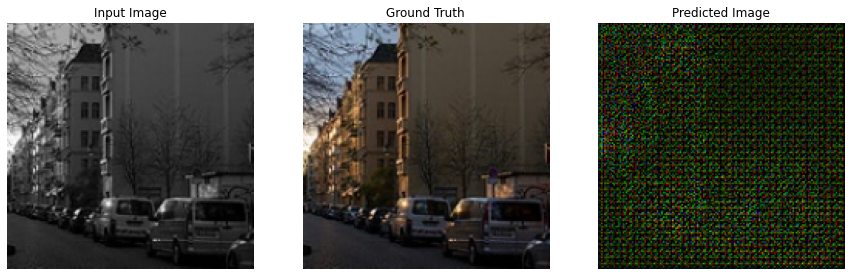

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


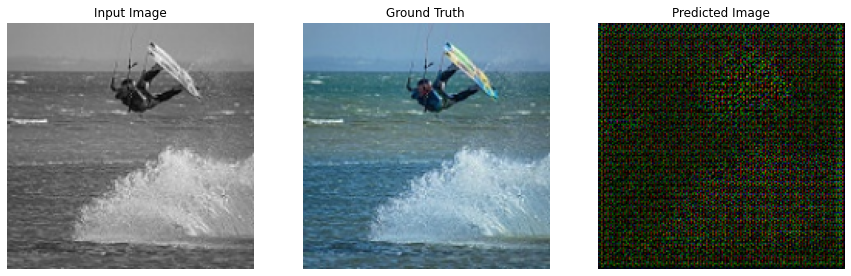

In [24]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

for example_input, example_target in tf.data.Dataset.zip((gray_dataset,color_dataset)).take(2):
  generate_images(generator, example_input, example_target)


### Entrenamiento

In [25]:
fit(tf.data.Dataset.zip((gray_dataset, color_dataset)),
    epochs = 10)

Epoch:  1

Time taken for epoch 1 is 84.28336596488953 sec

Epoch:  2

Time taken for epoch 2 is 78.55661940574646 sec

Epoch:  3

Time taken for epoch 3 is 78.5690188407898 sec

Epoch:  4

Time taken for epoch 4 is 78.61678099632263 sec

Epoch:  5

Time taken for epoch 5 is 78.55213689804077 sec

Epoch:  6

Time taken for epoch 6 is 78.50688600540161 sec

Epoch:  7

Time taken for epoch 7 is 78.58277988433838 sec

Epoch:  8

Time taken for epoch 8 is 78.61413240432739 sec

Epoch:  9

Time taken for epoch 9 is 78.44506192207336 sec

Epoch:  10

Time taken for epoch 10 is 79.61261916160583 sec



### Generar imágenes y métricas

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [26]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [tar[0],test_input[0], prediction[0]]
  title = ['Imagen a color', 'Imagen blanco y negro', 'Imagen predicha']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

In [30]:
def metrics(model, test_input, tar):
  prediction = model(test_input, training=True)
  mse1=mse(prediction[0],tar[0])
  rmse1=rmse(prediction[0], tar[0])
  psnr1=image_similarity_measures.quality_metrics.psnr(prediction[0], tar[0])
  #fsim1=image_similarity_measures.quality_metrics.fsim(prediction[0], tar[0])
  uqi1=uqi(prediction[0], tar[0])
  ssim1=image_similarity_measures.quality_metrics.ssim(prediction[0], tar[0])
  vif1=vifp(prediction[0], tar[0])

  return mse1, rmse1, psnr1, uqi1, ssim1, vif1

In [28]:
for example_input, example_target in tf.data.Dataset.zip((gray_dataset_t,color_dataset_t)).take(7):
  generate_images(generator, example_input, example_target)

Output hidden; open in https://colab.research.google.com to view.

In [31]:
mse_cGL, rmse_cGL, psnr_cGL, fsim_cGL, uqi_cGL, ssim_cGL, uiq_cGL, vif_cGL = [],[],[],[],[],[],[],[]
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

for example_input, example_target in tf.data.Dataset.zip((gray_dataset_t,color_dataset_t)).take(200):
  #prediction2 = generator(example_input, training=True)
  mseG,rsmeG,psnrG,uqiG,ssimG,vifG=metrics(generator, example_input, example_target)

  mse_cGL.append(mseG)
  rmse_cGL.append(rsmeG)
  psnr_cGL.append(psnrG)
  uqi_cGL.append(uqiG)
  ssim_cGL.append(ssimG)
  vif_cGL.append(vifG)

mse_CGL_m=np.mean(mse_cGL)
rmse_cGL_m=np.mean(rmse_cGL)
psnr_cGL_m=np.mean(psnr_cGL)
uqi_cGL_m=np.mean(uqi_cGL)
ssim_cGL_m=np.mean(ssim_cGL)
vif_cGL_m=np.mean(vif_cGL)

GAN_cGL=np.array([mse_CGL_m,rmse_cGL_m,psnr_cGL_m,uqi_cGL_m,ssim_cGL_m,vif_cGL_m])

# Comparación de resultados en los modelos

In [ ]:
import pandas as pd  

In [ ]:
metricas=['MSE','RMSE','PSNR','FSIM','UQI','SSIM','VIF']

In [ ]:
results=pd.DataFrame(columns=['AE sin concatenar','AE sin concatenar más capas','AE concatenado','AE concatenado más capas'])
results['AE sin concatenar']=AE_ncL
results['AE sin concatenar más capas']=AE_ncM
results['AE concatenado']=AE_cL
results['AE concatenado más capas']=AE_cM
results['Metrica']=metricas

In [ ]:
results=results.set_index('Metrica',drop=True)

In [ ]:
results.head(8)

,AE sin concatenar,AE sin concatenar más capas,AE concatenado,AE concatenado más capas
Metrica,,,,
MSE,0.007172,0.006462,0.006256,0.006086
RMSE,0.000019,0.000019,0.000017,0.000017
PSNR,95.039504,94.758902,96.088031,96.158390
FSIM,0.961650,0.929927,0.970350,0.968667
UQI,0.944186,0.946654,0.953323,0.951419
SSIM,0.999996,0.999998,0.999997,0.999997
VIF,0.980677,1.056835,0.976695,0.987062


In [32]:
metricas2=['MSE','RMSE','PSNR','UQI','SSIM','VIF']

In [33]:
results2=pd.DataFrame(columns=['GAN'])
results2['GAN']=GAN_cGL
results2['Metrica']=metricas2
results2=results2.set_index('Metrica',drop=True)

In [34]:
results2

,GAN
Metrica,
MSE,0.007252
RMSE,0.000020
PSNR,94.345327
UQI,0.943361
SSIM,0.999996
VIF,0.915260
